In [25]:
IS_OSC = False

In [26]:
# Setup script to run on OSC
# conda install scikit-learn matplotlib nltk seaborn
# pip install git+https://github.com/titipata/pubmed_parser.git@0.3.1
# conda install -c conda-forge hummingbird-ml
# conda install ipykernel
# ipython kernel install --user --name=thesis


In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.pipeline import Pipeline
import seaborn as sns
import pubmed_parser as pp
import csv
from tqdm import tqdm
from hummingbird.ml import convert

import warnings
warnings.filterwarnings('ignore')

Let's look at one pub-med dictionary entry:

In [28]:
if IS_OSC:
    data_path = "/ftp.ncbi.nlm.nih.gov/pubmed/baseline/"
else:
    data_path = '../../data/raw'
path_xml = pp.list_xml_path(data_path) # list all xml paths under directory
pubmed_dict = pp.parse_medline_xml(path_xml[0]) # dictionary output

Load it into a dataframe and output the head

In [29]:
df = pd.DataFrame(pubmed_dict)
df.head()

,title,issue,pages,abstract,journal,authors,pubdate,pmid,mesh_terms,publication_types,...,doi,references,delete,affiliations,pmc,other_id,medline_ta,nlm_unique_id,issn_linking,country
0,[Beta-blockers and arterial hypertension in th...,7(31),2807-9,,La Nouvelle presse medicale,Tcherdakoff|P|P|,1978,30970,D000319:Adrenergic beta-Antagonists; D005260:F...,D016428:Journal Article,...,,,False,,,,Nouv Presse Med,0312552,0301-1518,France
1,[beta-blockers and high risk pregnancies. View...,7(31),2811-2,,La Nouvelle presse medicale,Dubois|D|D|;Petitcolas|J|J|,1978,30971,D000070:Acebutolol; D000319:Adrenergic beta-An...,D016428:Journal Article,...,,,False,,,,Nouv Presse Med,0312552,0301-1518,France
2,[Surface defense mechanisms of the nasal mucosa].,33(35),1391-3,,"Polski tygodnik lekarski (Warsaw, Poland : 1960)",Makowska|W|W|;Zawisza|E|E|,1978,30972,D001424:Bacterial Infections; D002633:Chemotax...,D016428:Journal Article; D016454:Review,...,,,False,,,,Pol Tyg Lek,9705468,0032-3756,Poland
3,[Pharmacological treatment of coronary disease].,33(44),1721-4,,"Polski tygodnik lekarski (Warsaw, Poland : 1960)",Krotkiewski|A|A|,1978,30973,D000319:Adrenergic beta-Antagonists; D003327:C...,D016428:Journal Article,...,,,False,,,,Pol Tyg Lek,9705468,0032-3756,Poland
4,Treating the outpatient schizophrenic.,64(5),48-56,,Postgraduate medicine,Gelenberg|A J|AJ|,1978,30974,D000208:Acute Disease; D000553:Ambulatory Care...,D016428:Journal Article,...,10.1080/00325481.1978.11714969,,False,,,,Postgrad Med,0401147,0032-5481,England


Drop the missing abstracts

In [30]:
df = df[df['abstract'] != '']
df.shape

(13415, 22)

Get the unique mesh terms

In [31]:
mesh_terms_arr = []
[mesh_terms_arr.extend(mesh_terms.split('; ')) for mesh_terms in df.mesh_terms.to_list()]
unique_mesh_terms = set(mesh_terms_arr)

# Display the first 20 unique terms
list(unique_mesh_terms)[:20]

['D001058:Apomorphine',
 'D010555:Personality Inventory',
 'D005954:Glucosephosphate Dehydrogenase',
 'D000369:Aged, 80 and over',
 'D011197:Potassium Radioisotopes',
 'D015004:Yellow Fever',
 'D004825:Epiglottis',
 'D001886:Bordetella pertussis',
 'D000883:Anthropology',
 'D005609:Free Radicals',
 'D006428:Hemipelvectomy',
 'D006408:Hematoma, Subdural',
 'D006551:Hernia, Hiatal',
 'D010529:Peritoneal Cavity',
 'D016193:G1 Phase',
 'D005263:Femoral Artery',
 'D009470:Muscle Spindles',
 'D011738:Pyrilamine',
 'D001283:Atrioventricular Node',
 'D010405:Penicillinase']

Add the mesh terms to the dataframe as columns. This does take about 5 minutes to run per volume.

In [32]:
for mesh_term in tqdm(unique_mesh_terms):
    df[mesh_term] = df.mesh_terms.apply(lambda x: 1 if mesh_term in x else 0)

100%|██████████| 9214/9214 [01:18<00:00, 118.07it/s]


Display the head of the dataframe to see if the mesh terms were added

In [33]:
df.head()

,title,issue,pages,abstract,journal,authors,pubdate,pmid,mesh_terms,publication_types,...,D003063:Cnidaria,D006261:Headache,D010559:Personnel Management,D000075:Acepromazine,D014594:Uterine Neoplasms,D009029:Mosaic Viruses,D009108:Mumps Vaccine,D007417:Intestinal Polyps,D007165:Immunosuppression Therapy,D013229:Stearic Acids
10,[Isolation and properties of preparations the ...,14(5),683-9,The paper describes a modified method of isola...,Prikladnaia biokhimiia i mikrobiologiia,Shvedova|T A|TA|;Petrova|A N|AN|,1978,30978,"D015061:1,4-alpha-Glucan Branching Enzyme; D00...",D003160:Comparative Study; D004740:English Abs...,...,0,0,0,0,0,0,0,0,0,0
11,Potentiation of apomorphine action in rats by ...,9(3),375-8,Although the antiparkinsonian activity of 1-pr...,"Pharmacology, biochemistry, and behavior",Kostrzewa|R M|RM|;Kastin|A J|AJ|;Sobrian|S K|SK|,1978,30981,D000818:Animals; D001058:Apomorphine; D001522:...,D003160:Comparative Study; D016428:Journal Art...,...,0,0,0,0,0,0,0,0,0,0
14,Specific immune recognition by lymphocytes: an...,53(3),225-41,"In this review, we analyze data pertinent to t...",The Quarterly review of biology,Warr|G W|GW|;Marchalonis|J J|JJ|,1978,30984,"D000220:Adaptation, Biological; D000818:Animal...",D016428:Journal Article; D013487:Research Supp...,...,1,0,0,0,0,0,0,0,0,0
19,An analysis of measured and calculated calcium...,38(7),659-67,Potentiometrically measured ionized calcium (C...,Scandinavian journal of clinical and laborator...,Pedersen|K O|KO|,1978,30989,D000293:Adolescent; D000328:Adult; D000367:Age...,D016428:Journal Article,...,0,0,0,0,0,0,0,0,0,0
20,The value of immunoelectroosmophoresis (IEOP) ...,10(3),173-6,Immunoelectroosmophoresis (IEOP) has been used...,Scandinavian journal of infectious diseases,Wiernik|A|A|;Jarstrand|C|C|;Tunevall|G|G|,1978,30990,D000900:Anti-Bacterial Agents; D000942:Antigen...,D016428:Journal Article,...,0,0,0,0,0,0,0,0,0,0


Get the counts of the mesh terms

In [34]:
mesh_term_counts = []
for mesh_term in tqdm(unique_mesh_terms):
    mesh_term_counts.append((mesh_term, df[mesh_term].sum()))
mesh_term_counts = sorted(mesh_term_counts, key=lambda x: x[1], reverse=True)
mesh_term_df = pd.DataFrame(mesh_term_counts, columns=['mesh_term', 'count'])
mesh_term_df.head(20)

100%|██████████| 9214/9214 [00:01<00:00, 9138.26it/s] 


,mesh_term,count
0,D006801:Humans,6879
1,D000818:Animals,5824
2,D008297:Male,4396
3,D005260:Female,3955
4,D006863:Hydrogen-Ion Concentration,2786
5,D000328:Adult,2343
6,D051381:Rats,1855
7,D008875:Middle Aged,1758
8,D013997:Time Factors,1384
9,D013194:Staining and Labeling,1208


Plot the top 20 mesh terms

<AxesSubplot: xlabel='mesh_term'>

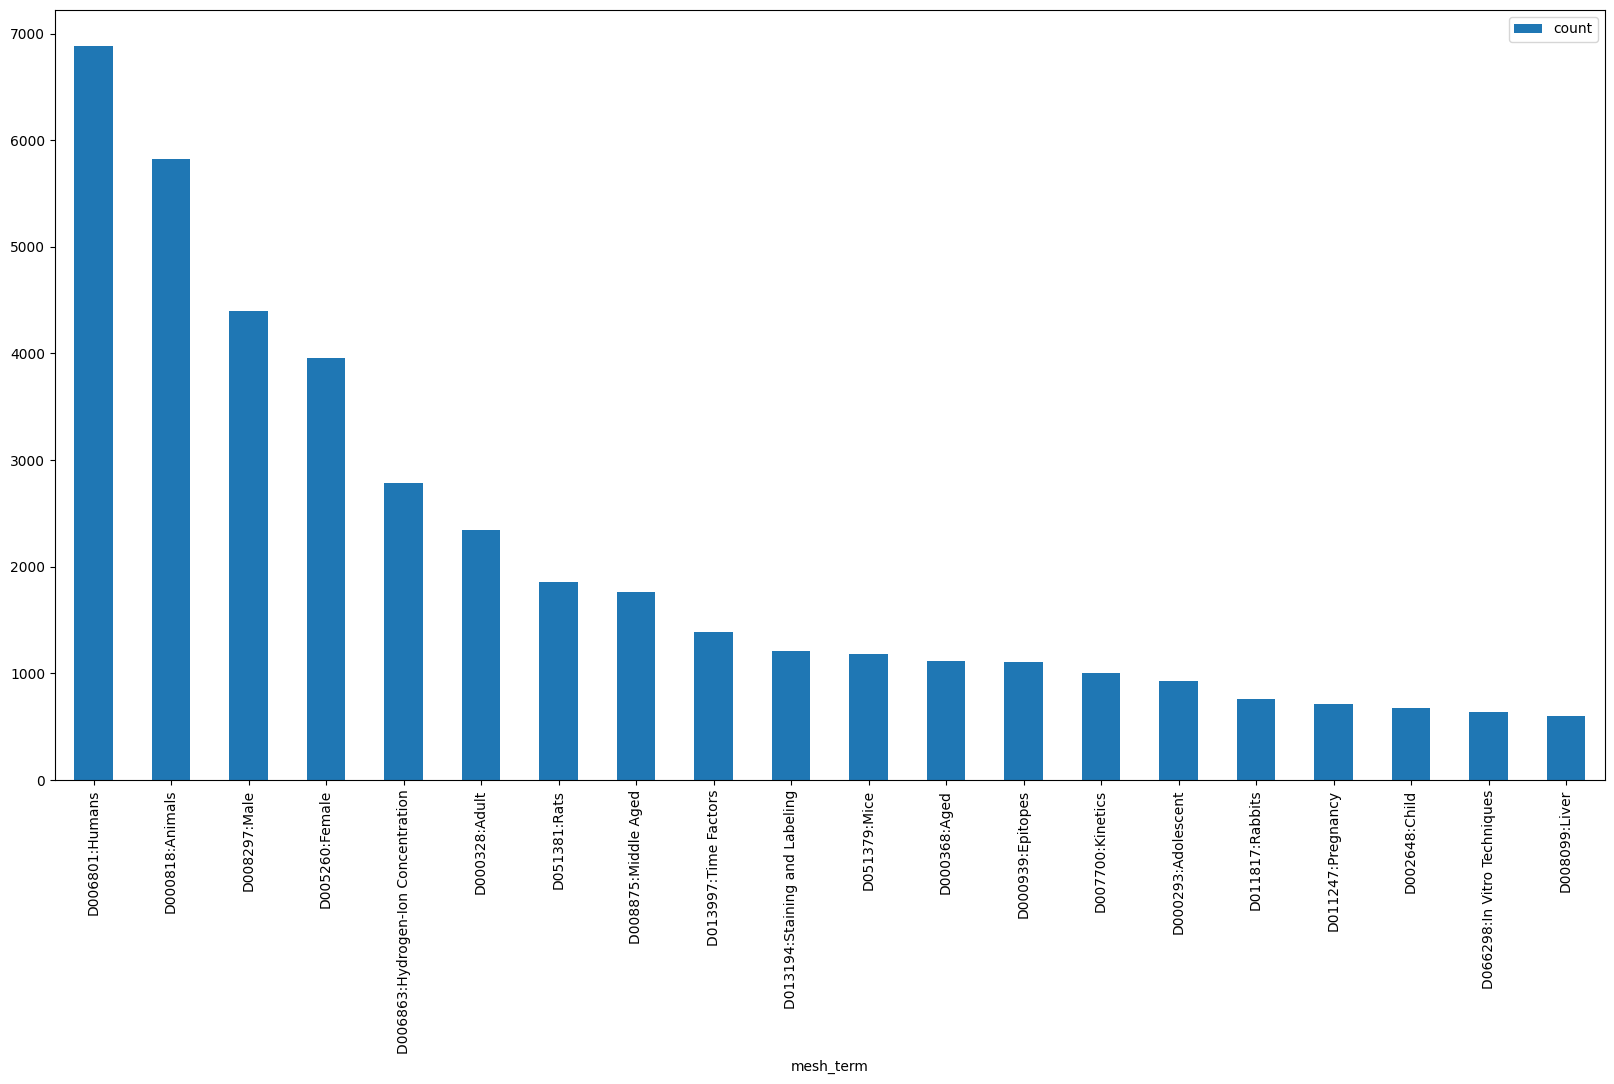

In [35]:
mesh_term_df.head(20).plot.bar(x='mesh_term', y='count', figsize=(20, 10))

How many mesh terms are there per article?

In [36]:

count_of_mesh_terms_per_article = df.iloc[:,22:].sum(axis=1).value_counts()


<AxesSubplot: >

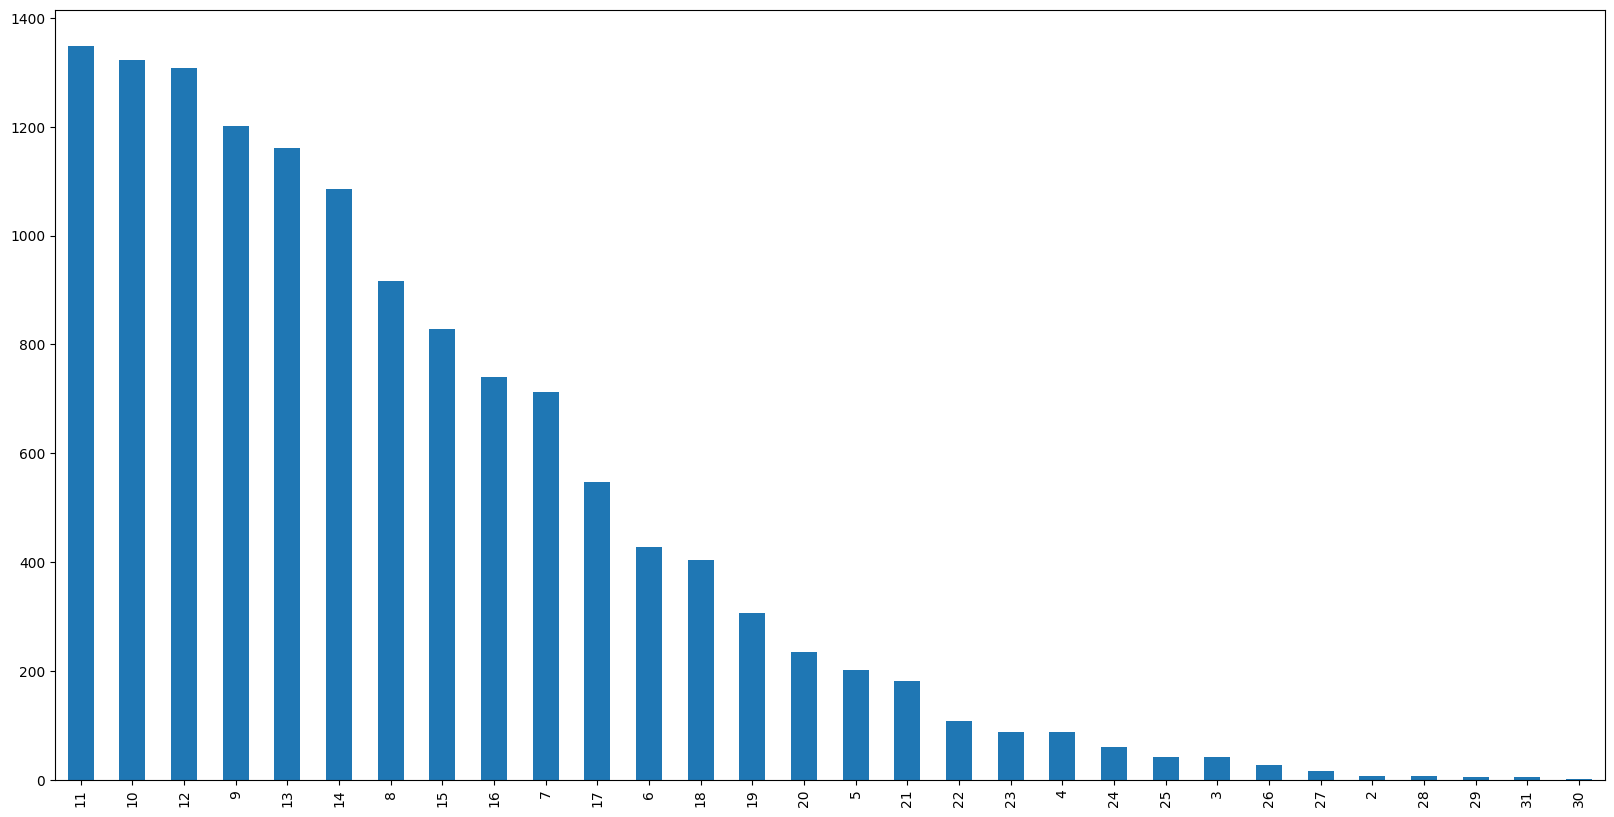

In [37]:
count_of_mesh_terms_per_article.plot.bar(figsize=(20, 10))

Let's start training and testing

In [38]:
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

In [39]:
X_train = train.abstract
X_test = test.abstract
print(X_train.shape)
print(X_test.shape)

(8988,)
(4427,)


Create a pipeline with a multi label classifier

In [42]:
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

with open('accuracy.csv','w') as f1:
    writer=csv.writer(f1, delimiter=',',lineterminator='\n')
    writer.writerow(['mesh_term','term_count','prediction_count','accuracy','precision','recall'])
    for mesh_term in tqdm(unique_mesh_terms):
        # train the model using X_dtm & y
        NB_pipeline.fit(X_train, train[mesh_term])
        # compute the testing accuracy
        prediction = NB_pipeline.predict(X_test)
        print('mesh_term: ', mesh_term)
        print(test[mesh_term].sum())
        print(prediction.sum())
        print('Test accuracy is {}'.format(accuracy_score(test[mesh_term], prediction)))
        print('Test precision is {}'.format(precision_score(test[mesh_term], prediction)))
        print('Test recall is {}'.format(recall_score(test[mesh_term], prediction)))


        writer.writerow([
            mesh_term, 
            test[mesh_term].sum(),
            prediction.sum(),
            accuracy_score(test[mesh_term], prediction), 
            precision_score(test[mesh_term], prediction), 
            recall_score(test[mesh_term], prediction)
            ])

  0%|          | 1/9214 [00:01<3:41:49,  1.44s/it]

mesh_term:  D001058:Apomorphine
17
0
Test accuracy is 0.9961599277162865
Test precision is 0.0
Test recall is 0.0


  0%|          | 2/9214 [00:02<3:36:32,  1.41s/it]

mesh_term:  D010555:Personality Inventory
0
0
Test accuracy is 1.0
Test precision is 0.0
Test recall is 0.0


  0%|          | 3/9214 [00:04<3:28:28,  1.36s/it]

mesh_term:  D005954:Glucosephosphate Dehydrogenase
14
0
Test accuracy is 0.9968375875310594
Test precision is 0.0
Test recall is 0.0


  0%|          | 4/9214 [00:05<3:24:35,  1.33s/it]

mesh_term:  D000369:Aged, 80 and over
0
0
Test accuracy is 1.0
Test precision is 0.0
Test recall is 0.0


  0%|          | 5/9214 [00:06<3:22:47,  1.32s/it]

mesh_term:  D011197:Potassium Radioisotopes
0
0
Test accuracy is 1.0
Test precision is 0.0
Test recall is 0.0


  0%|          | 6/9214 [00:08<3:22:28,  1.32s/it]

mesh_term:  D015004:Yellow Fever
3
0
Test accuracy is 0.999322340185227
Test precision is 0.0
Test recall is 0.0


  0%|          | 7/9214 [00:09<3:21:17,  1.31s/it]

mesh_term:  D004825:Epiglottis
1
0
Test accuracy is 0.9997741133950757
Test precision is 0.0
Test recall is 0.0


  0%|          | 8/9214 [00:10<3:19:18,  1.30s/it]

mesh_term:  D001886:Bordetella pertussis
7
0
Test accuracy is 0.9984187937655297
Test precision is 0.0
Test recall is 0.0


  0%|          | 9/9214 [00:11<3:16:16,  1.28s/it]

mesh_term:  D000883:Anthropology
2
0
Test accuracy is 0.9995482267901513
Test precision is 0.0
Test recall is 0.0


  0%|          | 10/9214 [00:13<3:14:59,  1.27s/it]

mesh_term:  D005609:Free Radicals
6
0
Test accuracy is 0.9986446803704541
Test precision is 0.0
Test recall is 0.0


  0%|          | 11/9214 [00:14<3:13:45,  1.26s/it]

mesh_term:  D006428:Hemipelvectomy
1
0
Test accuracy is 0.9997741133950757
Test precision is 0.0
Test recall is 0.0


  0%|          | 12/9214 [00:15<3:16:56,  1.28s/it]

mesh_term:  D006408:Hematoma, Subdural
4
0
Test accuracy is 0.9990964535803026
Test precision is 0.0
Test recall is 0.0


  0%|          | 13/9214 [00:16<3:16:28,  1.28s/it]

mesh_term:  D006551:Hernia, Hiatal
5
0
Test accuracy is 0.9988705669753783
Test precision is 0.0
Test recall is 0.0


  0%|          | 14/9214 [00:18<3:15:38,  1.28s/it]

mesh_term:  D010529:Peritoneal Cavity
3
0
Test accuracy is 0.999322340185227
Test precision is 0.0
Test recall is 0.0


  0%|          | 15/9214 [00:19<3:14:00,  1.27s/it]

mesh_term:  D016193:G1 Phase
1
0
Test accuracy is 0.9997741133950757
Test precision is 0.0
Test recall is 0.0


  0%|          | 16/9214 [00:20<3:14:55,  1.27s/it]

mesh_term:  D005263:Femoral Artery
3
0
Test accuracy is 0.999322340185227
Test precision is 0.0
Test recall is 0.0


  0%|          | 17/9214 [00:21<3:14:29,  1.27s/it]

mesh_term:  D009470:Muscle Spindles
0
0
Test accuracy is 1.0
Test precision is 0.0
Test recall is 0.0


  0%|          | 18/9214 [00:23<3:13:45,  1.26s/it]

mesh_term:  D011738:Pyrilamine
0
0
Test accuracy is 1.0
Test precision is 0.0
Test recall is 0.0


  0%|          | 19/9214 [00:24<3:14:58,  1.27s/it]

mesh_term:  D001283:Atrioventricular Node
4
0
Test accuracy is 0.9990964535803026
Test precision is 0.0
Test recall is 0.0


  0%|          | 20/9214 [00:26<3:24:13,  1.33s/it]

mesh_term:  D010405:Penicillinase
3
0
Test accuracy is 0.999322340185227
Test precision is 0.0
Test recall is 0.0


  0%|          | 21/9214 [00:27<3:21:54,  1.32s/it]

mesh_term:  D005191:Family Characteristics
5
0
Test accuracy is 0.9988705669753783
Test precision is 0.0
Test recall is 0.0


  0%|          | 22/9214 [00:28<3:22:11,  1.32s/it]

mesh_term:  D009280:Naphthaleneacetic Acids
2
0
Test accuracy is 0.9995482267901513
Test precision is 0.0
Test recall is 0.0


  0%|          | 23/9214 [00:29<3:20:43,  1.31s/it]

mesh_term:  D006328:Cardiac Catheterization
10
0
Test accuracy is 0.9977411339507567
Test precision is 0.0
Test recall is 0.0


  0%|          | 24/9214 [00:31<3:19:12,  1.30s/it]

mesh_term:  D011018:Pneumonia, Pneumococcal
7
0
Test accuracy is 0.9984187937655297
Test precision is 0.0
Test recall is 0.0


  0%|          | 25/9214 [00:32<3:20:44,  1.31s/it]

mesh_term:  D005837:Genitalia, Male
2
0
Test accuracy is 0.9995482267901513
Test precision is 0.0
Test recall is 0.0


  0%|          | 26/9214 [00:34<3:33:51,  1.40s/it]

mesh_term:  D012440:Saccharomyces
3
0
Test accuracy is 0.999322340185227
Test precision is 0.0
Test recall is 0.0


  0%|          | 27/9214 [00:35<3:48:27,  1.49s/it]

mesh_term:  D001170:Arthritis, Infectious
4
0
Test accuracy is 0.9990964535803026
Test precision is 0.0
Test recall is 0.0


  0%|          | 28/9214 [00:37<3:42:45,  1.45s/it]

mesh_term:  D012952:Societies
1
0
Test accuracy is 0.9997741133950757
Test precision is 0.0
Test recall is 0.0


  0%|          | 29/9214 [00:38<3:34:50,  1.40s/it]

mesh_term:  D008003:Phthiraptera
1
0
Test accuracy is 0.9997741133950757
Test precision is 0.0
Test recall is 0.0


  0%|          | 30/9214 [00:39<3:29:00,  1.37s/it]

mesh_term:  D010908:Pituitary Hormones, Anterior
2
0
Test accuracy is 0.9995482267901513
Test precision is 0.0
Test recall is 0.0


  0%|          | 31/9214 [00:41<3:26:49,  1.35s/it]

mesh_term:  D020964:Embryo Loss
1
0
Test accuracy is 0.9997741133950757
Test precision is 0.0
Test recall is 0.0


  0%|          | 32/9214 [00:42<3:22:57,  1.33s/it]

mesh_term:  D009807:Odontogenic Cysts
1
0
Test accuracy is 0.9997741133950757
Test precision is 0.0
Test recall is 0.0


  0%|          | 33/9214 [00:43<3:26:40,  1.35s/it]

mesh_term:  D001758:Blastomyces
1
0
Test accuracy is 0.9997741133950757
Test precision is 0.0
Test recall is 0.0


  0%|          | 34/9214 [00:45<3:23:22,  1.33s/it]

mesh_term:  D000432:Methanol
5
0
Test accuracy is 0.9988705669753783
Test precision is 0.0
Test recall is 0.0


  0%|          | 35/9214 [00:46<3:18:59,  1.30s/it]

mesh_term:  D007799:Lanatosides
0
0
Test accuracy is 1.0
Test precision is 0.0
Test recall is 0.0


  0%|          | 36/9214 [00:47<3:20:45,  1.31s/it]

mesh_term:  D002322:Career Mobility
0
0
Test accuracy is 1.0
Test precision is 0.0
Test recall is 0.0


  0%|          | 37/9214 [00:49<3:30:56,  1.38s/it]

mesh_term:  D011658:Pulmonary Fibrosis
3
0
Test accuracy is 0.999322340185227
Test precision is 0.0
Test recall is 0.0


  0%|          | 38/9214 [00:50<3:37:23,  1.42s/it]

mesh_term:  D000626:Aminopeptidases
4
0
Test accuracy is 0.9990964535803026
Test precision is 0.0
Test recall is 0.0


  0%|          | 38/9214 [00:52<3:30:21,  1.38s/it]


KeyboardInterrupt: 